In [1]:
import matplotlib.pyplot as plt
import gensim
import numpy as np
import pandas as pd
import spacy

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
import pyLDAvis.gensim

import os, re, operator, warnings
warnings.filterwarnings('ignore')  # Let's not pay heed to them right now
%matplotlib inline

In [2]:
df = pd.read_csv("./data/reddit/cm/askanincel_comments.csv")

In [3]:
sdf = pd.read_csv('subreddits.csv')
subreddits = sdf.values.tolist()

for s in subreddits:
    sub = str(s)[5:-5]
    print('sub', sub)     

    temp_df = pd.read_csv(f'./data/reddit/cm/{sub}_comments.csv')
    temp_serie = temp_df.Comment
    if s == subreddits[0]:
        serie = temp_serie
    else:
        serie = serie.append(temp_serie, ignore_index=True)

In [4]:
serie = df.Comment

In [5]:
serie.head()

0                               Larpers/satire/parody.
1    You should realise that at least a third of th...
2           Why would you ask this question to incels?
3    Men have a broader range of attraction. \n\nA ...
4    Would never date one. And they would never dat...
Name: Comment, dtype: object

In [6]:
serie.shape

(41127,)

In [7]:
serie = serie[serie != '[deleted]']

In [8]:
serie.shape

(41118,)

serie.to_csv("./data/reddit/cm/all_comments.csv")

## Pre-processing data

In [9]:
nlp = spacy.load("en")

In [10]:
my_stop_words = [u'say', u'\s', u'Mr', u'be', u'said', u'says', u'saying', u's', u'’s', u'\n\n', u' ']
for stopword in my_stop_words:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True

In [11]:
stl= pd.Series.tolist(serie)

In [14]:
texts, article, skl_texts = [], [], []
for comment in stl:
    try:
        doc = nlp(comment)
    except:
        continue
    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article!
        if not w.is_stop and not w.is_punct and not w.like_num:
            # we add the lematized version of the word
            article.append(w.lemma_)
        # assume each comment as a document
        if w.text == doc[-1].text:
            skl_texts.append(' '.join(article))
            texts.append(article)
            article = []

In [15]:
texts

[['larper', 'satire', 'parody'],
 ['realise', 'woman', 'genuinely', 'think', 'femcel', 'thing'],
 ['lay', 'hot', 'guy', 'hold', 'start', 'parody', 'frequency', 'user'],
 ['ask', 'question', 'incel'],
 ['man', 'broad', 'range', 'attraction'],
 ['guy',
  'fat',
  'short',
  'ugly',
  'asian',
  'Indian',
  'immediately',
  'find',
  'sizeable',
  'majority',
  'woman',
  'immediately',
  'turn'],
 ['basically', 'exist', 'woman', 'case'],
 ['date'],
 ['date'],
 ['acknowledge', 'existence'],
 ['call', 'ask', 'incel'],
 ['go'],
 ['conceive',
  'big',
  'disadvantage',
  'burden',
  'pregnancy',
  'birth',
  'grant',
  'fuckton',
  'hidden',
  'advantage',
  'core',
  'woman',
  'view',
  'inherently',
  'valuable'],
 ['man', 'expendable', 'history'],
 ['yes'],
 ['think',
  'answer',
  'question',
  'theoretically',
  'speak',
  'man',
  'woman',
  'enjoy',
  'sex'],
 ['second',
  'question',
  'enjoy',
  'sex',
  'entirely',
  'dependent',
  'attractiveness',
  'partner'],
 ['date'],
 ['goo

In [16]:
file = pd.Series(texts)
file.to_csv("texts.csv")

In [17]:
bigram = gensim.models.Phrases(texts)

In [18]:
texts = [bigram[line] for line in texts]

In [19]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [20]:
corpus[5][0:10]

[(8, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 2),
 (27, 1),
 (28, 1),
 (29, 1)]

## LSI

In [32]:
lsimodel = LsiModel(corpus=corpus, num_topics=6, id2word=dictionary)

In [33]:
lsimodel.show_topics()  

[(0,
  '0.581*"woman" + 0.324*"man" + 0.268*"like" + 0.247*"incel" + 0.231*" " + 0.183*"people" + 0.166*"not" + 0.151*"think" + 0.150*"want" + 0.128*"look"'),
 (1,
  '-0.638*"woman" + 0.346*"incel" + -0.312*"man" + 0.296*"like" + 0.273*"people" + 0.212*"not" + 0.170*" " + 0.138*"think" + 0.113*"know" + 0.091*"want"'),
 (2,
  '0.824*"incel" + -0.460*"like" + -0.179*" " + -0.122*"people" + -0.093*"look" + -0.078*"guy" + -0.076*"girl" + 0.075*"woman" + -0.063*"feel" + -0.056*"good"'),
 (3,
  '-0.758*" " + 0.542*"not" + 0.213*"like" + -0.132*"people" + 0.124*"be" + 0.067*"want" + 0.057*"\n" + -0.057*"incel" + 0.047*"know" + 0.046*"mean"'),
 (4,
  '-0.645*"like" + 0.484*"not" + -0.260*"incel" + 0.239*"people" + 0.236*"man" + 0.180*" " + -0.157*"woman" + 0.147*"\n" + 0.111*"⣿_⣿" + 0.084*"know"'),
 (5,
  '-0.536*"⣿_⣿" + -0.521*"\n" + -0.307*"⣿" + 0.245*"not" + 0.221*"man" + -0.149*"⣶" + 0.144*" " + -0.125*"⠿" + -0.105*"⠀_⠀" + -0.104*"people"')]

## HDP

In [34]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [46]:
hdpmodel.show_topics(num_topics=20)

[(0,
  '0.021*woman + 0.013*like + 0.013*man + 0.013*incel + 0.011*people + 0.010*not + 0.009*think + 0.008*want + 0.008*  + 0.007*know + 0.007*look + 0.007*guy + 0.006*thing + 0.005*girl + 0.005*good + 0.005*try + 0.004*get + 0.004*\n + 0.004*be + 0.004*way'),
 (1,
  '0.009*woman + 0.006*incel + 0.005*man + 0.005*like + 0.005*not + 0.004*people + 0.004*think + 0.003*want + 0.003*know + 0.003*\n + 0.003*look + 0.002*  + 0.002*guy + 0.002*way + 0.002*thing + 0.002*female + 0.002*good + 0.002*girl + 0.002*try + 0.002*gt'),
 (2,
  '0.006*woman + 0.004*like + 0.004*incel + 0.003*man + 0.003*not + 0.003*people + 0.003*think + 0.003*\n + 0.003*want + 0.002*know + 0.002*look + 0.002*fuck + 0.002*be + 0.002*girl + 0.002*thing + 0.002*guy + 0.002*  + 0.002*good + 0.001*sex + 0.001*try'),
 (3,
  '0.006*woman + 0.005*like + 0.004*incel + 0.003*man + 0.003*\n + 0.003*not + 0.003*people + 0.003*think + 0.002*want + 0.002*know + 0.002*look + 0.002*guy + 0.002*girl + 0.002*  + 0.002*thing + 0.002*get

## LDA

In [36]:
ldamodel = LdaModel(corpus=corpus, num_topics=6, id2word=dictionary)

In [37]:
ldamodel.show_topics()

[(0,
  '0.028*"woman" + 0.020*"yes" + 0.020*"mean" + 0.019*"fuck" + 0.018*"man" + 0.016*"sex" + 0.013*"people" + 0.012*"love" + 0.011*"virgin" + 0.010*"want"'),
 (1,
  '0.025*"not" + 0.025*"want" + 0.024*"girl" + 0.023*"guy" + 0.016*"like" + 0.016*"woman" + 0.012*"know" + 0.012*"friend" + 0.012*"get" + 0.010*"ugly"'),
 (2,
  '0.057*"woman" + 0.036*"man" + 0.034*"incel" + 0.031*" " + 0.019*"think" + 0.015*"hate" + 0.014*"like" + 0.013*"female" + 0.011*"people" + 0.010*"life"'),
 (3,
  '0.022*"like" + 0.014*"people" + 0.014*"feel" + 0.014*"be" + 0.013*"know" + 0.012*"yeah" + 0.012*"bad" + 0.011*"think" + 0.011*"work" + 0.011*"person"'),
 (4,
  '0.032*"look" + 0.022*"incel" + 0.019*"\n" + 0.015*"like" + 0.015*"good" + 0.015*"try" + 0.014*"help" + 0.012*"think" + 0.011*"matter" + 0.010*"tell"'),
 (5,
  '0.022*"people" + 0.013*"post" + 0.012*"stop" + 0.012*"like" + 0.011*"foid" + 0.010*"incel" + 0.009*"true" + 0.009*"Chad" + 0.008*"lie" + 0.008*"get"')]

## pyLDAvis

In [47]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.103083 -0.070422       1        1  22.004536
1     -0.075126  0.039734       2        1  20.308016
4      0.018981  0.139293       3        1  14.968719
3      0.047420  0.215381       4        1  14.928775
0     -0.171594 -0.164148       5        1  14.520438
5      0.283401 -0.159838       6        1  13.269517, topic_info=     Category          Freq          Term         Total  loglift  logprob
8     Default  12194.000000         woman  12194.000000  30.0000  30.0000
1353  Default   4397.000000                 4397.000000  29.0000  29.0000
19    Default   7027.000000           man   7027.000000  28.0000  28.0000
178   Default   2907.000000          girl   2907.000000  27.0000  27.0000
125   Default   4246.000000          look   4246.000000  26.0000  26.0000
16    Default   8093.000000         incel   8093.000000  25.0000  25.0000
55    Default   1739.000000           yes   1739.000000  24.0000  24.0000
25    Default   3453.000000           guy   3453.000000  23.0000  23.0000
271   Default   2404.000000          mean   2404.000000  22.0000  22.0000
545   Default   2325.000000          hate   2325.000000  21.0000  21.0000
192   Default   2344.000000            \n   2344.000000  20.0000  20.0000
355   Default   1249.000000          help   1249.000000  19.0000  19.0000
58    Default   3028.000000           sex   3028.000000  18.0000  18.0000
135   Default   5554.000000          want   5554.000000  17.0000  17.0000
100   Default   4878.000000           not   4878.000000  16.0000  16.0000
68    Default   3200.000000          fuck   3200.000000  15.0000  15.0000
250   Default   1101.000000          yeah   1101.000000  14.0000  14.0000
848   Default    992.000000          stop    992.000000  13.0000  13.0000
72    Default   6127.000000        people   6127.000000  12.0000  12.0000
862   Default    994.000000        virgin    994.000000  11.0000  11.0000
258   Default   1430.000000          post   1430.000000  10.0000  10.0000
203   Default   1063.000000        matter   1063.000000   9.0000   9.0000
826   Default   1210.000000          foid   1210.000000   8.0000   8.0000
136   Default   1907.000000           bad   1907.000000   7.0000   7.0000
69    Default   3338.000000          good   3338.000000   6.0000   6.0000
912   Default   2799.000000            be   2799.000000   5.0000   5.0000
161   Default   2187.000000  relationship   2187.000000   4.0000   4.0000
129   Default   1628.000000          love   1628.000000   3.0000   3.0000
261   Default    785.000000          real    785.000000   2.0000   2.0000
111   Default   1200.000000          sure   1200.000000   1.0000   1.0000
...       ...           ...           ...           ...      ...      ...
485    Topic6    317.467926         bitch    328.384491   1.9859  -5.5206
944    Topic6    292.543762          lmao    305.629211   1.9759  -5.6024
605    Topic6    425.471527      argument    468.711182   1.9229  -5.2278
187    Topic6    240.733551            /r    252.577881   1.9717  -5.7973
1214   Topic6    186.653061         stand    189.709000   2.0035  -6.0517
246    Topic6    604.932922           sub    751.411133   1.8029  -4.8759
258    Topic6   1041.490845          post   1430.548950   1.7023  -4.3326
89     Topic6    746.357117          true    982.776428   1.7445  -4.6658
139    Topic6    426.962982         sorry    510.437408   1.8411  -5.2243
1749   Topic6    512.455505          rape    638.845337   1.7993  -5.0418
1190   Topic6    550.095459       comment    704.951660   1.7717  -4.9709
826    Topic6    839.047241          foid   1210.346558   1.6533  -4.5487
364    Topic6    623.715027        \n\n\n    862.800476   1.6952  -4.8453
3714   Topic6    257.049347          evil    284.707947   1.9175  -5.7317
1778   Topic6    371.371399        better    520.395386   1.6823  -5.3638
72     Topic6   1709.251221        people   612

## Topic Coherence

In [39]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [40]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=texts, dictionary=dictionary, window_size=10).get_coherence()

In [41]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

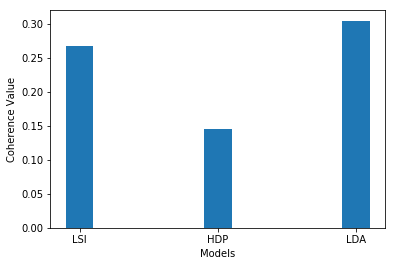

In [42]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence],
                   ['LSI', 'HDP', 'LDA'])

# PyLDAvis 20

In [43]:
ldamodel2 = LdaModel(corpus=corpus, num_topics=20, id2word=dictionary)

In [44]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel2, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
11    -0.164922 -0.025497       1        1  8.779018
12    -0.103484  0.130115       2        1  6.674340
6     -0.198684 -0.055794       3        1  6.632066
14     0.004859  0.279327       4        1  6.092647
4     -0.094055  0.004101       5        1  5.576015
8      0.000450  0.203912       6        1  5.443659
1     -0.166809 -0.134565       7        1  5.408223
7     -0.086231 -0.078834       8        1  5.309024
10    -0.137474 -0.015663       9        1  4.878224
15    -0.004272  0.005515      10        1  4.595081
2      0.065264 -0.076842      11        1  4.542060
0      0.076933 -0.020046      12        1  4.392214
5      0.141042 -0.139426      13        1  4.384956
17     0.129037  0.076895      14        1  4.257236
18     0.047292 -0.004570      15        1  4.256608
16     0.094978  0.037139      16        1  4.073486
3      0.042518 -0.040209      17        1  3.935870
19     0.084689  0.005817      18        1  3.640354
13     0.137927 -0.033793      19        1  3.590635
9      0.130941 -0.117582      20        1  3.538284, topic_info=     Category          Freq                               Term         Total  \
8     Default  14640.000000                              woman  14640.000000   
16    Default   9367.000000                              incel   9367.000000   
19    Default   8466.000000                                man   8466.000000   
1353  Default   5413.000000                                      5413.000000   
135   Default   6278.000000                               want   6278.000000   
6     Default   4353.000000                              thing   4353.000000   
100   Default   6036.000000                                not   6036.000000   
178   Default   3652.000000                               girl   3652.000000   
912   Default   3573.000000                                 be   3573.000000   
192   Default   2958.000000                                 \n   2958.000000   
69    Default   4074.000000                               good   4074.000000   
545   Default   2841.000000                               hate   2841.000000   
125   Default   5200.000000                               look   5200.000000   
322   Default   2835.000000                               time   2835.000000   
94    Default   3209.000000                                way   3209.000000   
58    Default   3457.000000                                sex   3457.000000   
55    Default   2217.000000                                yes   2217.000000   
248   Default   5392.000000                               know   5392.000000   
317   Default   2918.000000                             female   2918.000000   
696   Default   2523.000000                             friend   2523.000000   
123   Default   2355.000000                                 gt   2355.000000   
68    Default   3763.000000                               fuck   3763.000000   
31    Default   2386.000000                               ugly   2386.000000   
25    Default   4072.000000                                guy   4072.000000   
197   Default   3170.000000                                get   3170.000000   
503   Default   1817.000000                              point   1817.000000   
37    Default   1933.000000                                ask   1933.000000   
850   Default   2666.000000                               feel   2666.000000   
161   Default   2478.000000                       relationship   2478.000000   
35    Default   2434.000000                               date   2434.000000   
...       ...           ...                                ...           ...   
249   Topic20    250.856644                         make_sense    252.085953   
653   Topic20    235.180237                             animal    236.409195   
3073  Topic20    233.388748                             listen    234.6